In [5]:
import pandas as pd
adult_data = pd.read_csv("train_data.csv")
adult_data_test = pd.read_csv("test_data.csv")

In [6]:
from tensorflow import feature_column

In [33]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [98]:
cat_train = adult_data.iloc[:,[2,4,6,7,8,9,10,14]]
cat_test = adult_data_test.iloc[:,[2,4,6,7,8,9,10,14]]
frames = [cat_train, cat_test]
data_cat = pd.concat(frames) #categoric data of both datasets

In [85]:
def cat_onehot(data, train='true'):
  #data_cat = data.iloc[:,[2,4,6,7,8,9,10,14]]
  cat_encoder = OneHotEncoder()
  data_1hot = cat_encoder.fit_transform(data_cat)
  hold = pd.DataFrame(data_1hot.toarray())
  data_holder = data.iloc[:,[1,3,5,11,12,13]]

  almost_there = data_holder.join(hold)  

  if(train=='true'):
    there = almost_there.join(data.iloc[:,[15]])

    # In the original dataset ">50K" indicates 0.
    there['target'] = np.where(there['income']=='>50K', 0, 1)

    # Drop un-used columns.
    there = there.drop(columns=['income']) 
  else:
    there = almost_there

  return there

In [93]:
input_df = cat_onehot(adult_data)

In [94]:
target_df = input_df['target']
input_df = input_df.drop(columns=['target'])

In [18]:
import tensorflow as tf
from tensorflow import keras

In [56]:
nrmlzr = keras.layers.Normalization()
nrmlzr.adapt(input_df)

In [57]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[108]))

model.add(nrmlzr)

#1st fully connected Neural Network hidden-layer
model.add(keras.layers.Dense(60))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Activation('sigmoid'))

#2nd fully connected Neural Network hidden-layer
model.add(keras.layers.Dense(20))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Activation('relu'))

#Output layer
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 108)               0         
                                                                 
 normalization_2 (Normalizat  (None, 108)              217       
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 60)                6540      
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 activation_2 (Activation)   (None, 60)                0         
                                                                 
 dense_4 (Dense)             (None, 20)                1220      
                                                      

In [112]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
epch = 20

In [113]:
from sklearn.model_selection import train_test_split, cross_val_score

In [114]:
X_train, X_test, Y_train, Y_test = train_test_split(input_df, target_df, test_size=0.2, random_state=66) #save a small part of the train dataset to verify accuracy
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=66) #split the train dataset in train and validation
print(len(Y_train), 'train examples')
print(len(Y_val), 'validation examples')
print(len(Y_test), 'test examples')

20838 train examples
5210 validation examples
6512 test examples


In [ ]:
history = model.fit(X_train, Y_train, epochs=epch, validation_data=(X_val, Y_val), shuffle=True)

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import seaborn as sns

In [28]:
import matplotlib.pyplot as plt
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal

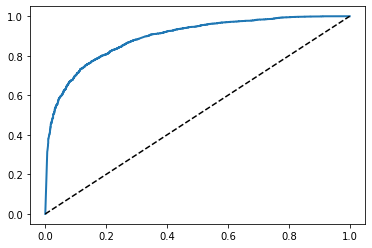

In [117]:
y_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test,y_proba)
plot_roc_curve(fpr, tpr)
plt.show()

In [118]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, y_proba)

0.8929878102777569

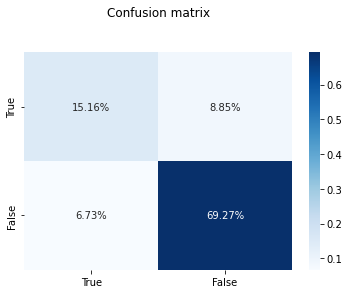

In [119]:
cf = confusion_matrix(Y_test, np.round(y_proba))
ax = plt.subplots()
ax = sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')
ax.set_title('Confusion matrix\n\n');
ax.xaxis.set_ticklabels(['True','False'])
ax.yaxis.set_ticklabels(['True','False'])
plt.show()

In [120]:
test_df = cat_onehot(adult_data_test, train='false')
test_prob = model.predict(test_df)

In [109]:
tid = adult_data_test['Id'].to_numpy() 

import csv

def create_otp(result, name='result.csv'):
  header = ['Id', 'income']

  rm = result[:, 0]

  with open(name, 'w') as file:
    writer = csv.writer(file)    
    writer.writerow(header)

    for i in range(rm.shape[0]): 
      if(rm[i]>=0.5):
        rr = '<=50K'
      else:
        rr = '>50K'
      l = str(tid[i]) + '-' + rr
      entries = l.split('-')         
      writer.writerow(entries)


In [121]:
create_otp(test_prob,name='Adult-PMR3508_One_Hot_encoded_and_normalized.csv')